In [22]:
import torch
import cv2 
import sys 
import os 
import numpy as np 
import matplotlib.pyplot as plt

#### MMDetection Element 
1. Dataset config 
2. Data Pipeline config 
3. Model config 
4. Data Pipeline config 
5. Train/Valid/Test conig 

#### MMDetection Dataset 
* https://github.com/open-mmlab/mmdetection/tree/master/mmdet
* MMDetection은 다양한 유형의 Dataset을 변환 class를 통해 지원 
* CustomDataset과 CocoDataset이 가장 쉽게 적용될 수 있는 Dataset 
    - CustomDataset
    - CocoDataset
    - VOCDataset 
    - WIDERFaceDataset 
    - XMLDataset 

#### Custom Dataset 
* 모든 image에 대한 annotation 정보들을 list 객체로 가짐 
* list 내의 개별 원소는 dict로 구성되며, 개별 dict는 1개 image에 대한 annotation을 가짐 
* 1개의 image는 여러개의 object bounding box와 labels annotation 정보들을 개별 dict로 가짐 
* 1개의 image
    - object bounding box(2차원 array)
    - object label(1차원 array)



In [23]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
!git clone https://github.com/open-mmlab/mmdetection.git
!cd mmdetection; python setup.py install

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
Cloning into 'mmdetection'...
remote: Enumerating objects: 24992, done.
remote: Total 24992 (delta 0), reused 0 (delta 0), pack-reused 24992
Receiving objects: 100% (24992/24992), 37.79 MiB | 27.21 MiB/s, done.
Resolving deltas: 100% (17517/17517), done.
No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
running install
running bdist_egg
running egg_info
creating mmdet.egg-info
writing mmdet.egg-info/PKG-INFO
writing dependency_links to mmdet.egg-info/dependency_links.txt
writing requirements to mmdet.egg-info/requires.txt
writing top-level names to mmdet.egg-info/top_level.txt
writing manifest file 'mmdet.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
adding license file 'LICENSE'
writing manifest file 'mmdet.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x8

In [3]:
from mmdet.apis import init_detector, inference_detector 
import mmcv 

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


In [4]:
!wget https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
!unzip kitti_tiny.zip > /dev/null

--2022-07-06 04:27:45--  https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
Resolving download.openmmlab.com (download.openmmlab.com)... 47.88.36.72
Connecting to download.openmmlab.com (download.openmmlab.com)|47.88.36.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6918271 (6.6M) [application/zip]
Saving to: ‘kitti_tiny.zip.1’

kitti_tiny.zip.1    100%[===================>]   6.60M  9.20MB/s    in 0.7s    

2022-07-06 04:27:47 (9.20 MB/s) - ‘kitti_tiny.zip.1’ saved [6918271/6918271]

replace kitti_tiny/val.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


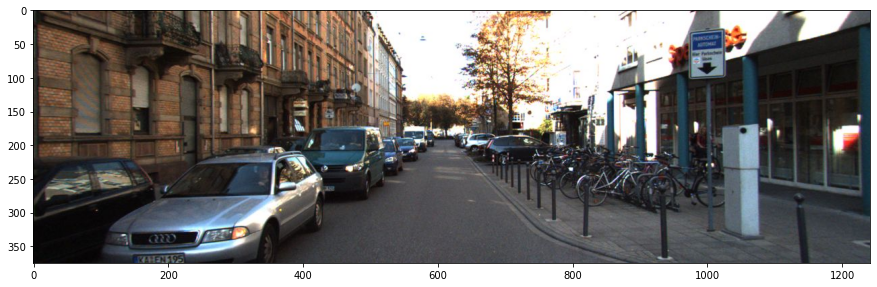

In [5]:
image = cv2.cvtColor(cv2.imread("/content/kitti_tiny/training/image_2/000068.jpeg"), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15, 10))
plt.imshow(image)

#### filename, width, height, annotation을 Key로 가지는 Dictionary를 image 개수대로 가지는 list를 생성 
- filename : image file name 
- width : image width 
- height : image height 
- ann : bounding box 와 label 정보를 가지는 dictionary 
    - bboxes 
        - 하나의 image에 있는 여러 object들의 numpy array
        - 4개의 좌표값(좌살단, 우하단)을 가지고 해당 image에 n 개의 object들이 있을 경우 array 의 shape는 (n, 4) 
    - labels 
        - 하나의 image에 있는 여러 object들의 numpy array.shape는 (n, ) 
    - bboxes_ignore 
        - 학습에 사용되지 않고 무시되는 bboxes
        - 무시되는 bboxes의 개수가 k개 이면 shape는 (k, 4) 
    - labels_ignore 
        - 학습에 사용되지 않고 무시되는 labels 
        - 무시되는 labels의 개수가 k개 이면 (k, )


#### Custom Dataset format 
* Dataset을 위한 Config 설정(data_root, ann_file, img_prefix)
    1. CustomDataset를 위한 MMDetection Framework에 등록 
    2. Confog에 설정된 주요값으로 CustomDataset 객체 생성

#### data_root, ann_file, img_prefix의 활용 
* Dataset은 training, validation, test용으로 각각 만들어 질 수 있어야 함 
* Source data들의 training, validation, test 분리유형 
    1. image들과 annotation 파일이 training, validation, test용 directory에 별도 분리 
    2. 별도의 meta 파일에서  training, validation, test용 image들과 annotation 파일을 지정 
    3.  image들은  training, validation, test용 directory 별로 분리, annotation은  training, validation, test용으로 하나만 가짐

    



In [6]:
import copy 
import os.path as osp 
import cv2 
import mmcv 
import numpy as np 

In [7]:
from mmdet.datasets.builder import DATASETS 
from mmdet.datasets.custom import CustomDataset

In [8]:
@DATASETS.register_module(force=True)
class KittyTinyDataset(CustomDataset):
    CLASSES = ("Car", "Truck", "Pedistrian", "Cyclist") 

    # def __init__(self, ann_file, pipeline, classes=None, data_root=None, img_prefix="", , ):
    #     self.ann_file = ann_file
    #     self.data_root = data_root 
    #     self.img_prefix = img_prefix 
    #     self.CLASSES = self.get_classes(classes)
    
    def load_annotations(self, ann_file):
        print(f"self.data_root : {self.data_root} \nself.ann_file : {self.ann_file}, \nself.img_prefix : {self.img_prefix}")
        cat2label = {k:i for i, k in enumerate(self.CLASSES)}
        image_list = mmcv.list_from_file(self.ann_file)

        data_infos = []

        for image_id in image_list :
            filename = "{0:}/{1:}.jpeg".format(self.img_prefix, image_id)
            image = cv2.imread(filename)
            height, width = image.shape[:2]

            data_info = {"filename" : str(image_id) +".jpeg",
                         "width":width,
                         "height":height}

            label_prefix = self.img_prefix.replace("image_2", "label_2")
            lines = mmcv.list_from_file(osp.join(label_prefix, str(image_id)+".txt"))

            content = [line.strip().split(" ") for line in lines]

            bbox_names = [x[0] for x in content]

            bboxes = [[float(info) for info in x[4:8]] for x in content]

            gt_bboxes = []
            gt_labels = []
            gt_bboxes_ignore = []
            gt_labels_ignore = []

            for bbox_name, bbox in zip(bbox_names, bboxes):
                if bbox_name in cat2label:
                    gt_bboxes.append(bbox)
                    gt_labels.append(cat2label[bbox_name])
                else :
                    gt_bboxes_ignore.append(bbox)
                    gt_labels_ignore.append(-1)
            
            data_anno = {
                "bboxes":np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4), 
                "labels":np.array(gt_labels, dtype=np.long),
                "bboxes_ignore" : np.array(gt_bboxes_ignore, dtype=np.float32).reshape(-1, 4),
                "labels_ignore" : np.array(gt_labels_ignore, dtype=np.long)

            }

            data_info.update(ann=data_anno)

            data_infos.append(data_info)

        return data_infos

In [9]:
config_file = '/content/mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
checkpoint_file = '/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

In [10]:
!cd mmdetection; mkdir checkpoints
!wget -O /content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth

mkdir: cannot create directory ‘checkpoints’: File exists
--2022-07-06 04:28:37--  http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.88.36.72
Connecting to download.openmmlab.com (download.openmmlab.com)|47.88.36.72|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167287506 (160M) [application/octet-stream]
Saving to: ‘/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’

/content/mmdetectio 100%[===================>] 159.54M  13.5MB/s    in 12s     

2022-07-06 04:28:50 (13.5 MB/s) - ‘/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’ saved [167287506/167287506]



In [11]:
from mmcv import Config 

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.

In [12]:
from mmdet.apis import set_random_seed

cfg.dataset_type = 'KittyTinyDataset'
cfg.data_root = '/content/kitti_tiny/'

cfg.data.train.type = 'KittyTinyDataset'
cfg.data.train.data_root = '/content/kitti_tiny/'
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = 'training/image_2'

cfg.data.val.type = 'KittyTinyDataset'
cfg.data.val.data_root = '/content/kitti_tiny/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'training/image_2'

cfg.data.test.type = 'KittyTinyDataset'
cfg.data.test.data_root = '/content/kitti_tiny/'
cfg.data.test.ann_file = 'val.txt'
cfg.data.test.img_prefix = 'training/image_2'

cfg.model.roi_head.bbox_head.num_classes = 4
cfg.load_from = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

cfg.work_dir = './tutorial_exps'

cfg.optimizer.lr = 0.02 / 8

cfg.lr_config.warmup = None
cfg.log_config.interval = 10

cfg.lr_config.policy = 'step'

cfg.evaluation.metric = 'mAP'
cfg.evaluation.interval = 12
cfg.checkpoint_config.interval = 12

cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_w

In [13]:
from mmdet.apis import set_random_seed


cfg.dataset_type = 'KittyTinyDataset'
cfg.data_root = '/content/kitti_tiny/'

cfg.data.train.type = 'KittyTinyDataset'
cfg.data.train.data_root = '/content/kitti_tiny/'
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = 'training/image_2'

cfg.data.val.type = 'KittyTinyDataset'
cfg.data.val.data_root = '/content/kitti_tiny/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'training/image_2'

cfg.data.test.type = 'KittyTinyDataset'
cfg.data.test.data_root = '/content/kitti_tiny/'
cfg.data.test.ann_file = 'val.txt'
cfg.data.test.img_prefix = 'training/image_2'

cfg.model.roi_head.bbox_head.num_classes = 4
cfg.load_from = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

cfg.work_dir = './tutorial_exps'
cfg.optimizer.lr = 0.02 / 8

cfg.lr_config.warmup = None
cfg.log_config.interval = 10

cfg.lr_config.policy = 'step'

cfg.evaluation.metric = 'mAP'
cfg.evaluation.interval = 12
cfg.checkpoint_config.interval = 12
cfg.device = "cuda"
cfg.data.train.pipeline=[
            dict(type='LoadImageFromFile'),
            dict(type='LoadAnnotations', with_bbox=True),
            dict(type='Resize', img_scale=(1500, 900), keep_ratio=True),
            dict(type='RandomFlip', flip_ratio=0.5),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='Pad', size_divisor=32),
            dict(type='DefaultFormatBundle'),
            dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
        ]

cfg.data.val.pipeline=[
            dict(type='LoadImageFromFile'),
            dict(
                type='MultiScaleFlipAug',
                img_scale=(1500, 900),
                flip=False,
                transforms=[
                    dict(type='Resize', keep_ratio=True),
                    dict(type='RandomFlip'),
                    dict(
                        type='Normalize',
                        mean=[123.675, 116.28, 103.53],
                        std=[58.395, 57.12, 57.375],
                        to_rgb=True),
                    dict(type='Pad', size_divisor=32),
                    dict(type='ImageToTensor', keys=['img']),
                    dict(type='Collect', keys=['img'])
                ])
        ]
  
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='Resize', img_scale=(1500, 900), keep_ratio=True),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
]
cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1500, 900),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='Pad', size_divisor=32),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img'])
        ])
]
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)


print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_w

In [14]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

datasets = [build_dataset(cfg.data.train)]

self.data_root : /content/kitti_tiny/ 
self.ann_file : /content/kitti_tiny/train.txt, 
self.img_prefix : /content/kitti_tiny/training/image_2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int`

In [15]:
datasets

[
 KittyTinyDataset Train dataset with number of images 50, and instance counts: 
 +----------+-------+-----------+-------+----------------+-------+-------------+-------+---------------+-------+
 | category | count | category  | count | category       | count | category    | count | category      | count |
 +----------+-------+-----------+-------+----------------+-------+-------------+-------+---------------+-------+
 | 0 [Car]  | 147   | 1 [Truck] | 7     | 2 [Pedistrian] | 0     | 3 [Cyclist] | 7     | -1 background | 4     |
 +----------+-------+-----------+-------+----------------+-------+-------------+-------+---------------+-------+]

In [16]:
CLASSES = ("Car", "Truck", "Pedestrian", "Cyclist")
cat2label = {k:i for i, k in enumerate(CLASSES)}
print(cat2label)

{'Car': 0, 'Truck': 1, 'Pedestrian': 2, 'Cyclist': 3}


In [17]:
model = build_detector(cfg.model, train_cfg=cfg.get("train_cfg"), test_cfg=cfg.get("test_cfg"))
model.CLASSES = datasets[0].CLASSES

In [18]:
pwd

'/content'

In [19]:
%cd mmdetection

/content/mmdetection


In [20]:
pwd

'/content/mmdetection'

In [26]:
torch.cuda.is_available()

False

In [28]:
image_list = mmcv.list_from_file("/content/kitti_tiny/train.txt")
image_list

['000000',
 '000001',
 '000002',
 '000003',
 '000004',
 '000005',
 '000006',
 '000007',
 '000008',
 '000009',
 '000010',
 '000011',
 '000012',
 '000013',
 '000014',
 '000015',
 '000016',
 '000017',
 '000018',
 '000019',
 '000020',
 '000021',
 '000022',
 '000023',
 '000024',
 '000025',
 '000026',
 '000027',
 '000028',
 '000029',
 '000030',
 '000031',
 '000032',
 '000033',
 '000034',
 '000035',
 '000036',
 '000037',
 '000038',
 '000039',
 '000040',
 '000041',
 '000042',
 '000043',
 '000044',
 '000045',
 '000046',
 '000047',
 '000048',
 '000049']

In [ ]:
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)